# 

# Intro to Scikit-Learn

From: [Kaggle Temperature-Salinity + Geodata](https://www.kaggle.com/code/angelosorge/temperature-salinity-geodata)

## Regression

### Context

The CalCOFI data set represents the world’s longest (1949-present) and most complete (more than 50,000 sampling stations) oceanographic and larval fish data time series. The physical, chemical, and biological data collected at regular time and space intervals help document climatic cycles in the California Current and a range of biological responses to them. CalCOFI research drew world attention to the biological response to the dramatic Pacific warming event in 1957-58 and introduced the term “El Niño” into the scientific literature.

CalCOFI conducts quarterly cruises off southern and central California, collecting a suite of hydrographic and biological data on the station and underway. Data collected at depths down to 500 m include temperature, salinity, oxygen, phosphate, silicate, nitrate and nitrite, chlorophyll, transmissometer, PAR, C14 primary productivity, phytoplankton biodiversity, zooplankton biomass, and zooplankton biodiversity.

### Scope

We would like to know how we could predict the temperature of the water based on the salinity and the depth, as well as possibly other available features.

In [182]:
import platform
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from tqdm.notebook import tqdm
import textwrap

### Data

[Main Website: CalCOFI](https://calcofi.com/)

[Bottle-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/bottle-field-descriptions)

[Cast-Dataset](https://new.data.calcofi.com/index.php/database/calcofi-database/cast-table-column-descriptions)

In [183]:
%config InlineBackend.figure_format="retina"  # For high DPI display

sns.set_style("darkgrid")
sns.set_context("notebook")

plotly.offline.init_notebook_mode(connected=True)

tqdm.pandas()

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.5.x

1.7.2


### Utility Functions

In [184]:
def pprint_var(**kwargs):
    for k, v in kwargs.items():
        print(f"{k} = {v:.4g}")

In [185]:
def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    # Calculate R² score
    r2 = r2_score(y_test, y_pred)

    print(f"Linear Regression Results (Depth only):")
    print(f"RMSE: {rmse:.4f} °C")
    print(f"R² Score: {r2:.4f}")

In [186]:
def print_formatted_response(header: str, body: str, width: int = 80):
    separator = "=" * width
    print(separator)
    print(header)
    print(separator)
    print(textwrap.fill(body, width=width))
    print(separator)

#### Data loading

In [187]:
DATA = Path("data")    # Change to your data folder
assert DATA.exists()

In [188]:
bottle_raw_df = pd.read_csv(DATA / "bottle.csv", low_memory=False, encoding="latin1")

In [189]:
bottle_info_df = pd.read_csv(
    DATA / "Bottle Field Descriptions.csv",
    encoding="cp1252",
).drop(columns=["Unnamed: 3"])

In [190]:
bottle_info_df[bottle_info_df["Field Name"] == "STheta"]

,Field Name,Units,Description
8,STheta,kilograms per cubic meter,"Potential Density (Sigma Theta), Kg/M³"


In [191]:
bottle_info_df

,Field Name,Units,Description
0,Cst_Cnt,n.a.,"Cast Count - All CalCOFI casts ever conducted,..."
1,Btl_Cnt,n.a.,Bottle Count - All CalCOFI bottles ever sample...
2,Sta_ID,n.a.,Line and Station [Line] [Station]
3,Depth_ID,n.a.,Uses the Cast_ID prefix ([Century]-[Year][Mont...
4,Depthm,meters,Bottle depth in meters
...,...,...,...
57,TA1,micromoles per kilogram,Total Alkalinity micromoles per kilogram solution
58,TA2,micromoles per kilogram,Total Alkalinity micromoles per kilogram solut...
59,pH1,pH scale,pH (the degree of acidity/alkalinity of a solu...
60,pH2,pH scale,pH (the degree of acidity/alkalinity of a solu...


In [192]:
bottle_df = bottle_raw_df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()
del bottle_raw_df
bottle_df

,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
0,1,0,10.500,33.44000,NaN,25.64900
1,1,8,10.460,33.44000,NaN,25.65600
2,1,10,10.460,33.43700,NaN,25.65400
3,1,19,10.450,33.42000,NaN,25.64300
4,1,20,10.450,33.42100,NaN,25.64300
...,...,...,...,...,...,...
895366,35644,304,7.303,26.67160,1.526,26.67160
895367,35644,379,6.606,26.82726,0.843,26.82726
895368,35644,400,6.420,26.86069,0.733,26.86069
895369,35644,500,5.877,27.01054,0.393,27.01054


In [193]:
bottle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895371 entries, 0 to 895370
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Cst_Cnt  895371 non-null  int64  
 1   Depthm   895371 non-null  int64  
 2   T_degC   884402 non-null  float64
 3   Salnty   848015 non-null  float64
 4   O2ml_L   725630 non-null  float64
 5   STheta   842675 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 41.0 MB


#### Cleaning

Remove the NaN values

<span style="color:red">Implement your solution below</span>

In [194]:

bottle_df = bottle_df[~bottle_df.isnull().any(axis=1)]


### Data Analysis

#### Plot Correlation Matrix with Seaborn

<span style="color:red">Implement your solution below</span>

<Axes: >

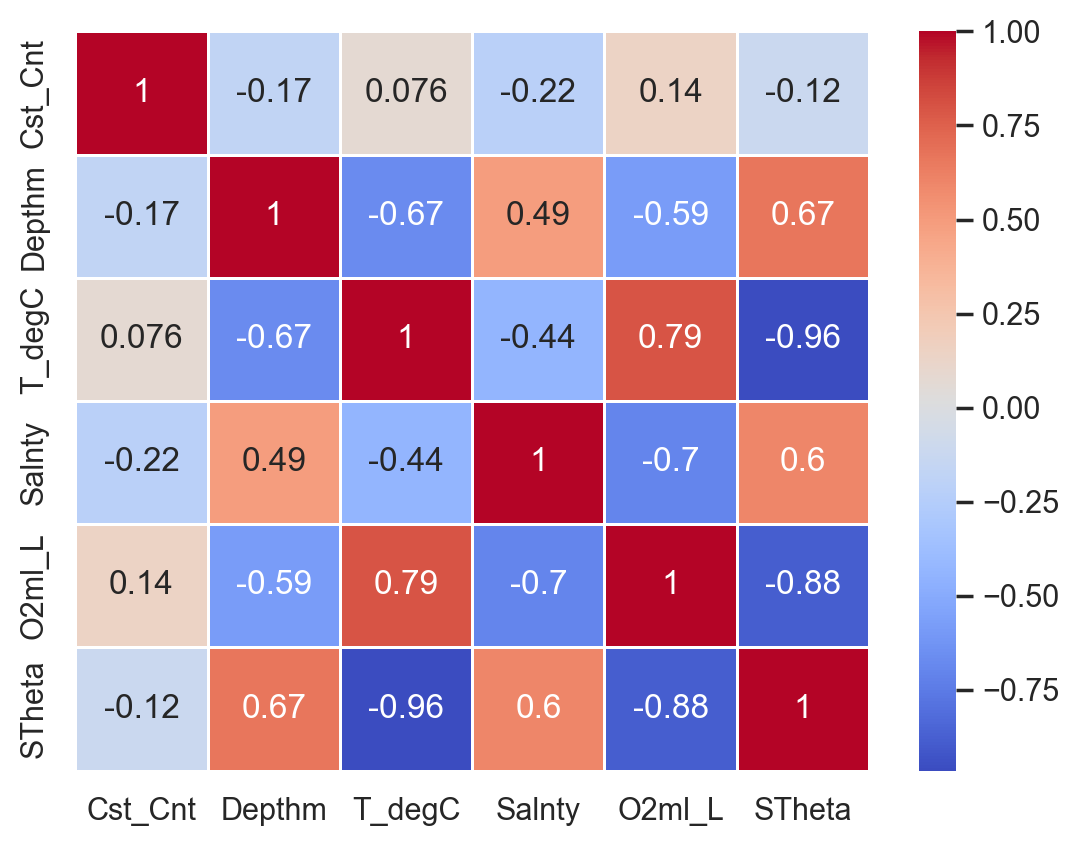

In [195]:
scorr = bottle_df.corr(numeric_only=True)
sns.heatmap(scorr, annot=True, cmap='coolwarm', linewidths=0.5)

#### Correlation Plots

Select from the correlation matrix the 4 features involved in the most correlated pairs and plot their relationship.

<span style="color:red">Implement your solution below</span>

In [196]:
np.fill_diagonal(scorr.values, 0)
top_pairs = scorr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_4_pairs = top_pairs.head(4)
print("Top 4 correlated pairs:\n", top_4_pairs)

Top 4 correlated pairs:
 T_degC  STheta    0.964932
O2ml_L  STheta    0.884589
T_degC  O2ml_L    0.792845
O2ml_L  Salnty    0.698052
dtype: float64


In [197]:
top_features = pd.unique(top_4_pairs.index.get_level_values(0).tolist() + top_4_pairs.index.get_level_values(1).tolist())
print("Top features:", top_features)

Top features: ['T_degC' 'O2ml_L' 'STheta' 'Salnty']


/var/folders/k5/h5f0st755j93yh496pf0gwtr0000gn/T/ipykernel_76531/918171752.py:1: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



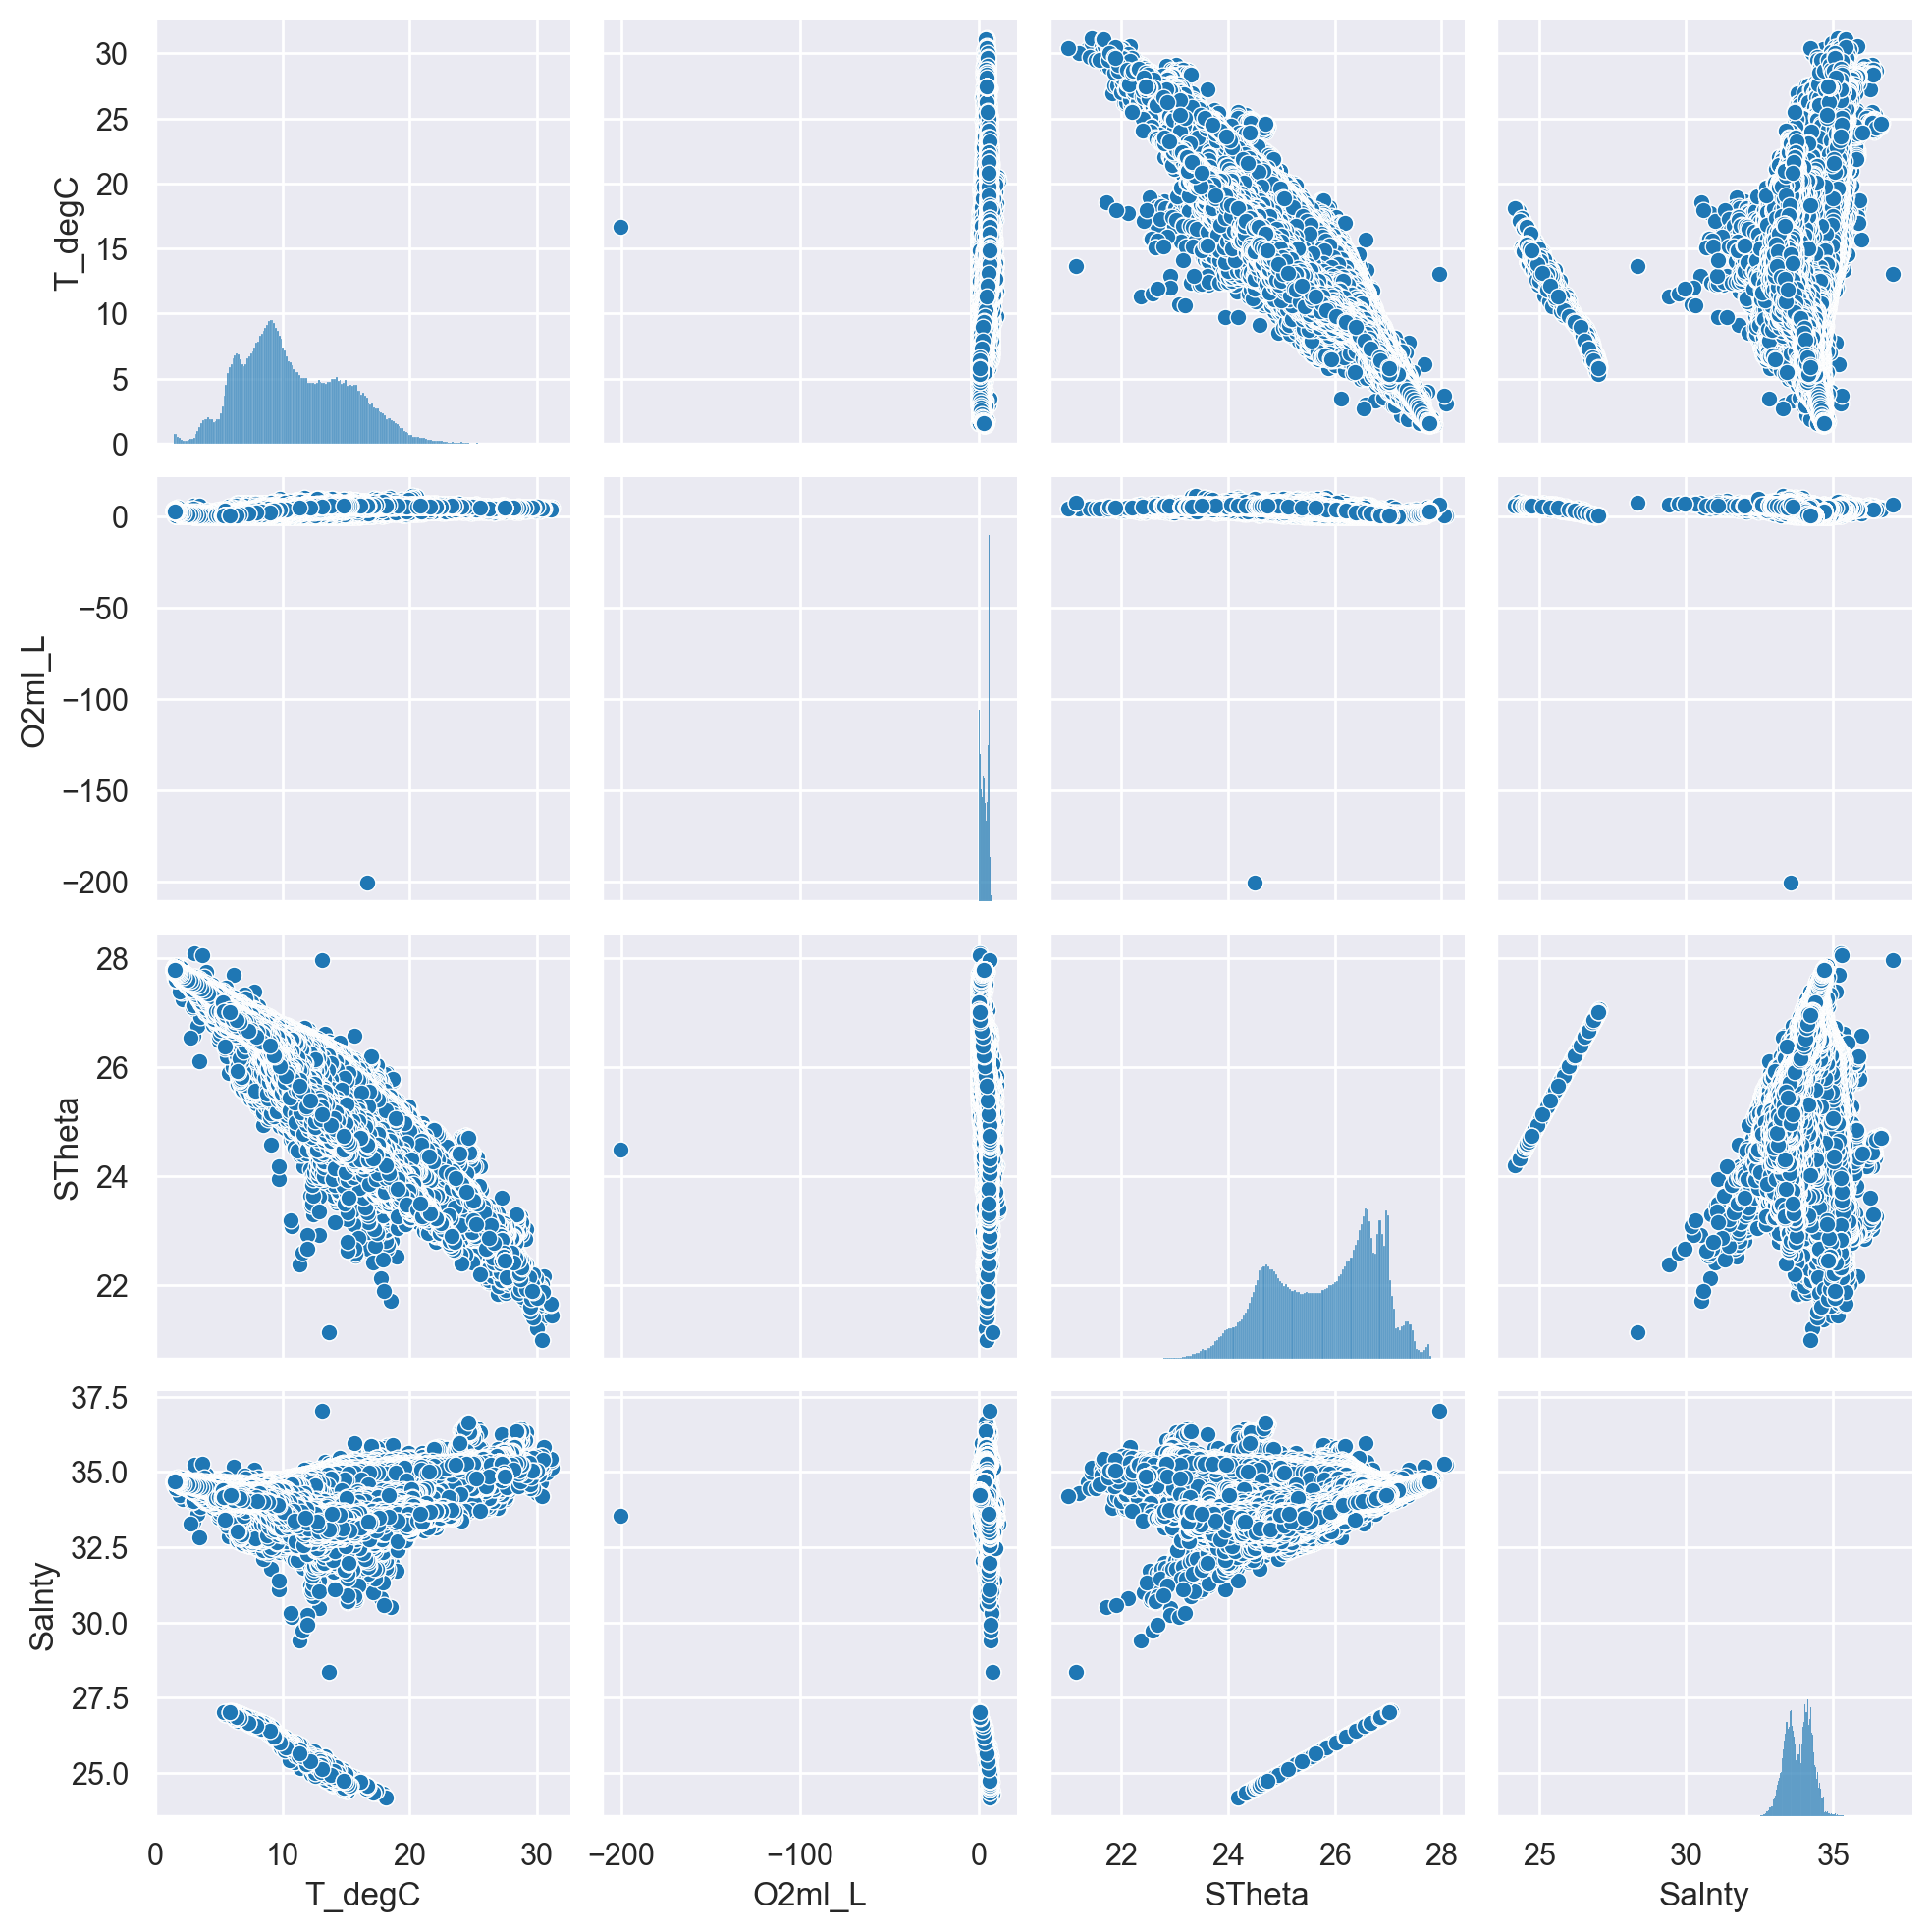

In [198]:
sns.pairplot(bottle_df[top_features])

#### Depth – Temperature – Salinity

*   The Temperature as a function of the Depth

*   The Salinity as a function of the Depth

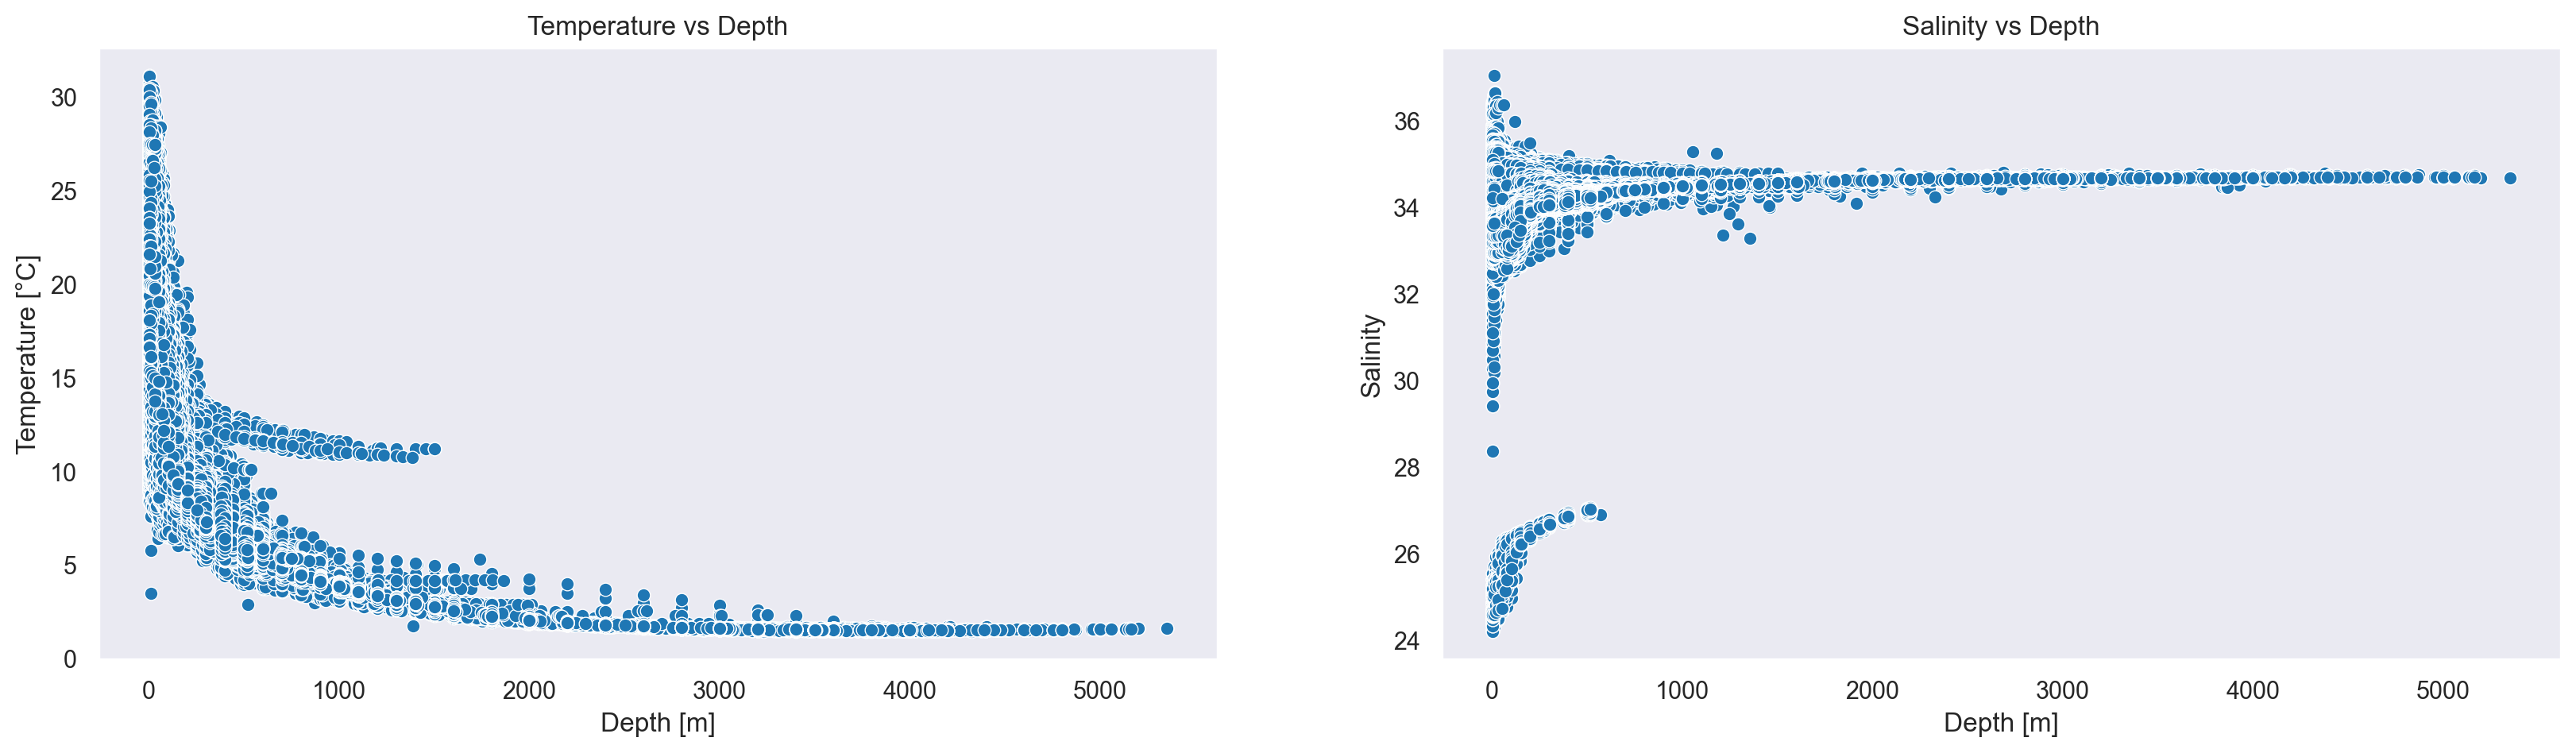

In [199]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
ax[0].set(
    xlabel="Depth [m]",
    ylabel="Temperature [°C]",
    title="Temperature vs Depth",
)
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity vs Depth")
ax[1].grid()

As we can see from the image above, temperature and salinity trace a hyperbolic trend as depth changes:

- In the first plot, some points in the upper part of the image show a different trend from the rest of the graph. It is an unexpected behavior because, for instance, at around 1000 m depth, the expected temperature is around 5°C, but we also find temperatures between 10°C and 15°C (https://www.windows2universe.org/earth/Water/temp.html).

- In the second plot, the points converge asymptotically from both high and low salinity values. It means salinity increases with depth in some ocean areas and vice versa.

Suppose we isolate data points with salinity values in the range above the salinity values in the deepest ocean area. In that case, we observe an alternative trend highlighted in the Temperature-Depth graph.

In [200]:
max_depth_salnty = bottle_df.loc[bottle_df.Depthm.idxmax()].Salnty
max_depth_salnty += 0.1  # Margin to stay on the upper side of the asymptote
pprint_var(max_depth_salnty=max_depth_salnty)

bottle_hi_salt_df = bottle_df[bottle_df.Salnty > max_depth_salnty]
bottle_hi_salt_df   # with max_depth_salnty = 34.85: 6818 rows × 6 columns

max_depth_salnty = 34.78


,Cst_Cnt,Depthm,T_degC,Salnty,O2ml_L,STheta
9204,305,1180,3.10,35.250,0.49,28.083
40328,1303,854,4.01,34.930,1.85,27.736
41497,1339,415,7.80,35.090,0.28,27.381
55857,1809,2142,1.98,34.790,1.85,27.817
55862,1809,2688,1.73,34.810,2.47,27.855
...,...,...,...,...,...,...
479617,19189,11,27.49,34.839,4.62,22.442
479618,19189,20,27.47,34.838,4.59,22.449
479619,19189,30,27.45,34.837,4.55,22.455
479620,19189,31,27.45,34.837,4.55,22.455


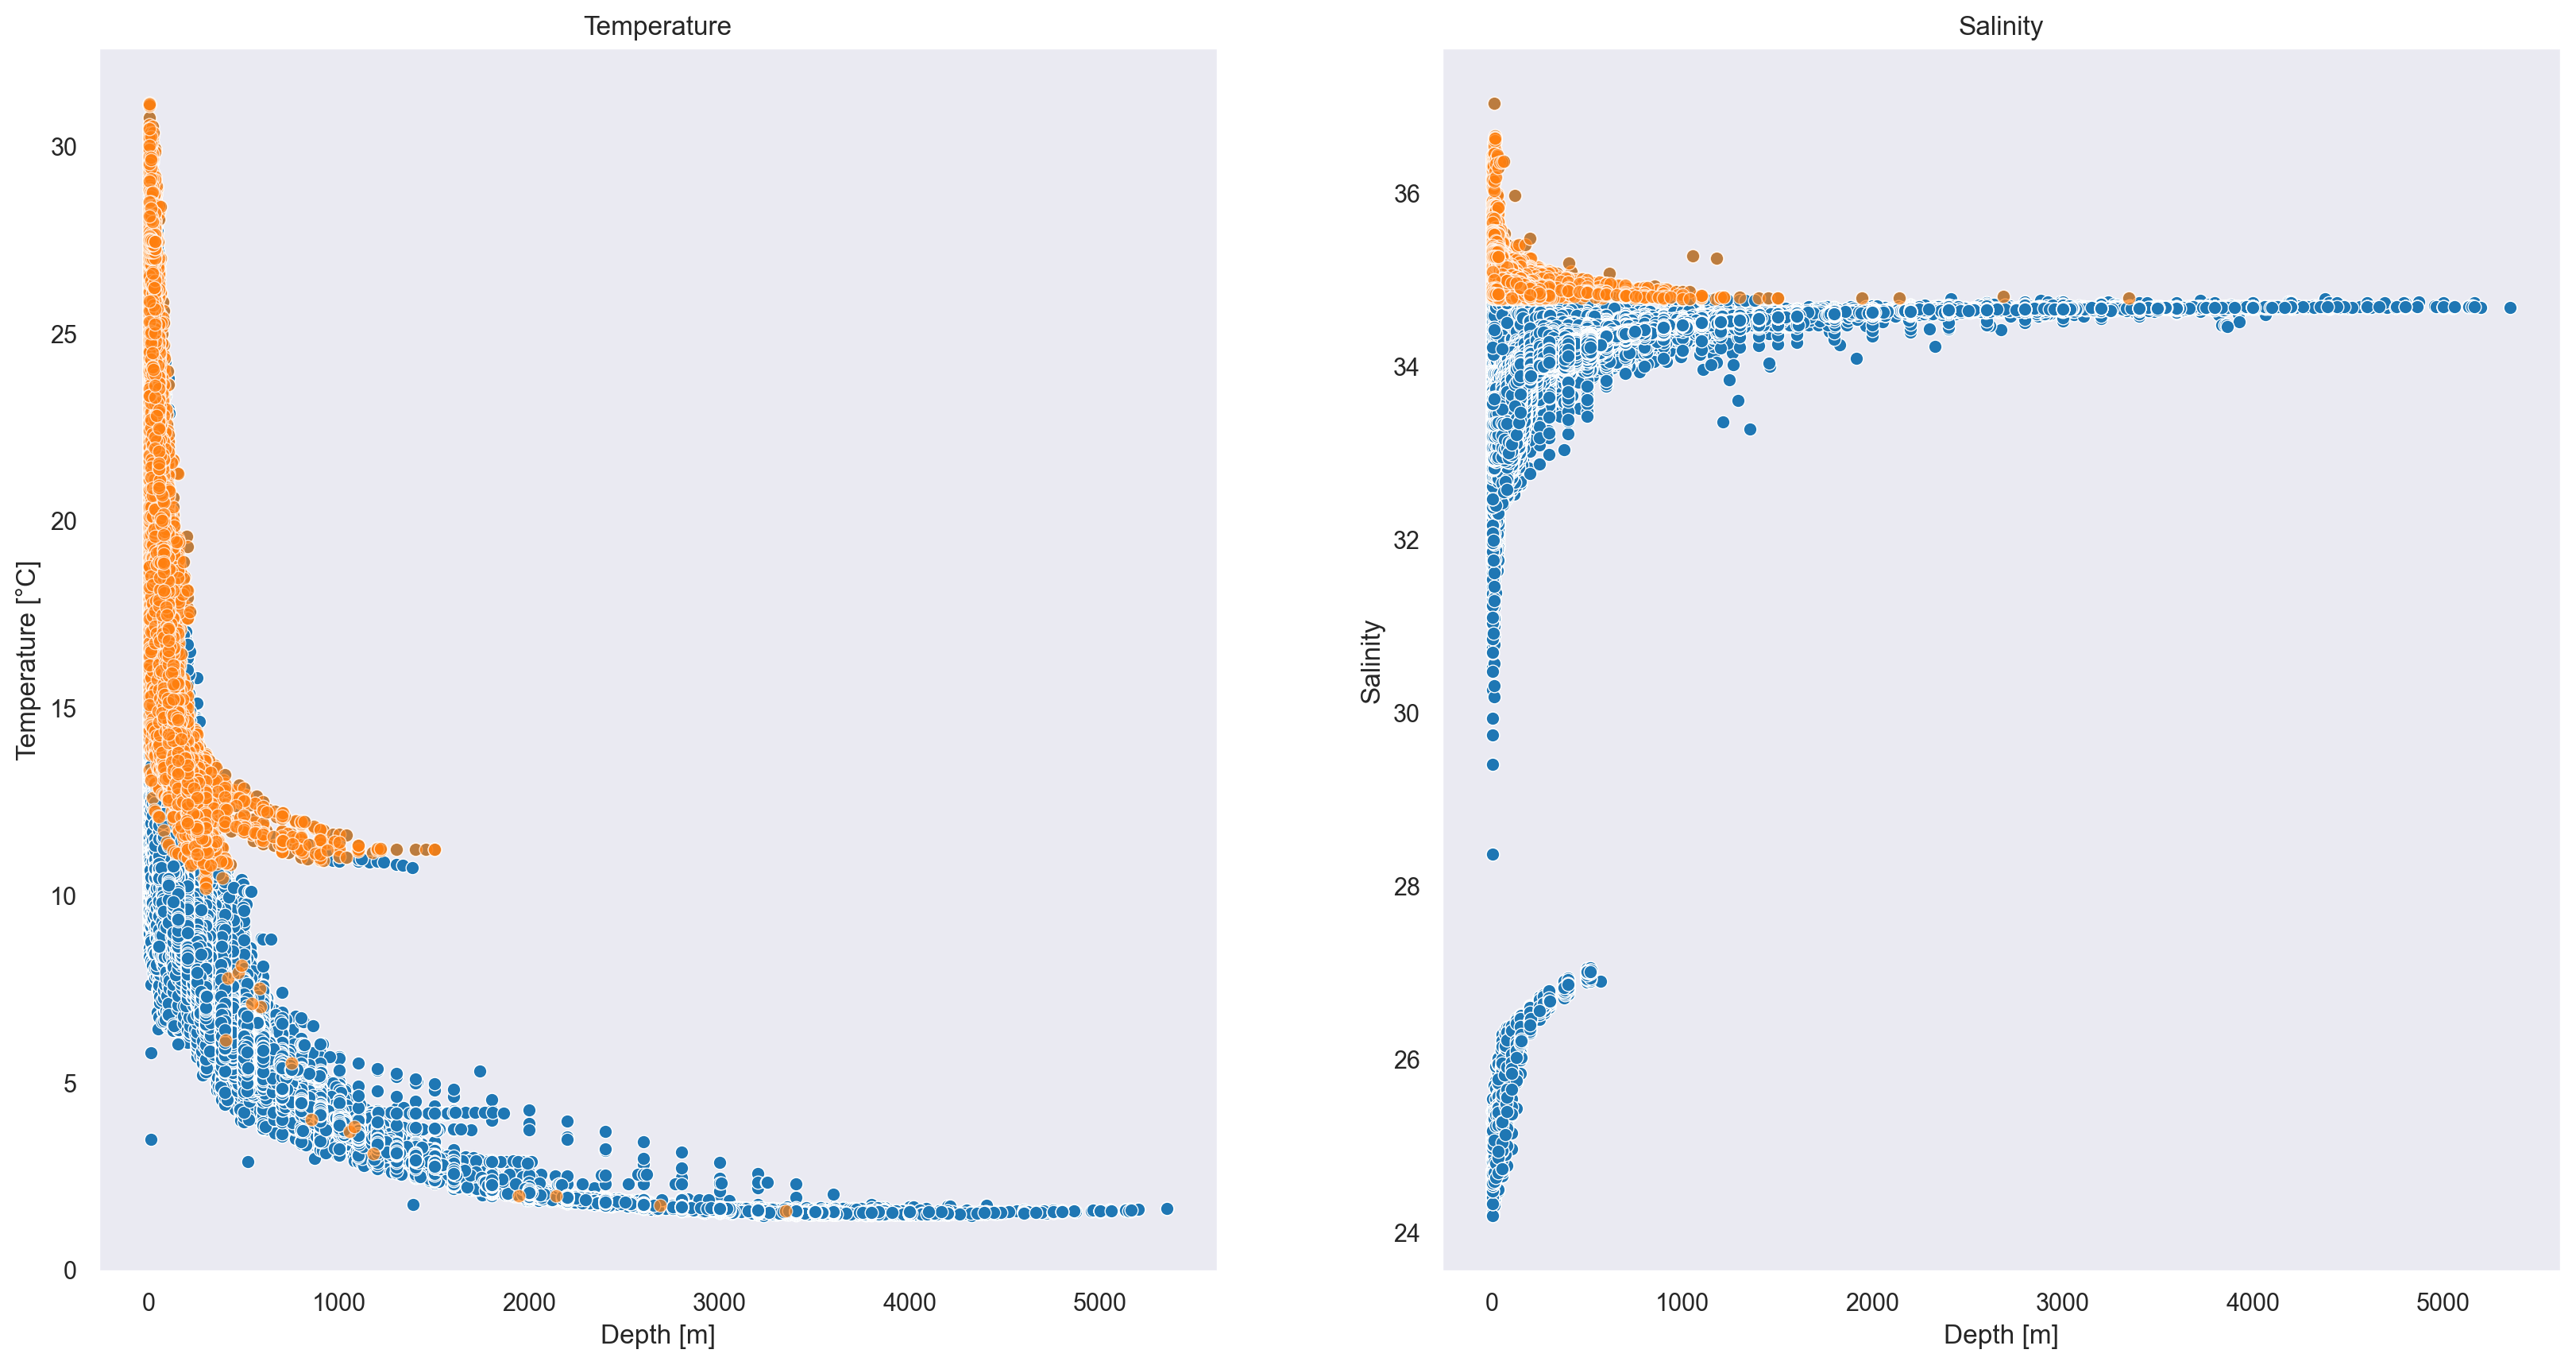

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
g1 = sns.scatterplot(data=bottle_df, x="Depthm", y="T_degC", ax=ax[0])
g1 = sns.scatterplot(
    bottle_hi_salt_df,
    x="Depthm",
    y="T_degC",
    ax=ax[0],
    alpha=0.7,
)
ax[0].set(xlabel="Depth [m]", ylabel="Temperature [°C]", title="Temperature")
ax[0].grid()
g2 = sns.scatterplot(data=bottle_df, x="Depthm", y="Salnty", ax=ax[1])
g2 = sns.scatterplot(
    data=bottle_hi_salt_df, x="Depthm", y="Salnty", ax=ax[1], alpha=0.7
)
ax[1].set(xlabel="Depth [m]", ylabel="Salinity", title="Salinity")
ax[1].grid()

### Predictive Models

#### Splitting the Dataset

<span style="color:red">Implement your solution below</span>

In [202]:
X = bottle_df[['Cst_Cnt', 'Depthm', 'Salnty', 'O2ml_L', 'STheta']]
y = bottle_df['T_degC']
X.shape, y.shape

((690692, 5), (690692,))

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [204]:
y_test.min()

np.float64(1.49)

In [205]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((587088, 5), (103604, 5), (587088,), (103604,))

#### Linear Regression

*   Try predicting the temperature based on depth only.

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted line.

<span style="color:red">Implement your solution below</span>

In [206]:
X_train_dep = X_train[['Depthm']]
X_test_dep = X_test[['Depthm']]

In [207]:
lin_reg = LinearRegression()

lin_reg.fit(X_train_dep, y_train)

y_pred = lin_reg.predict(X_test_dep)

In [208]:
y_train.min()

np.float64(1.44)

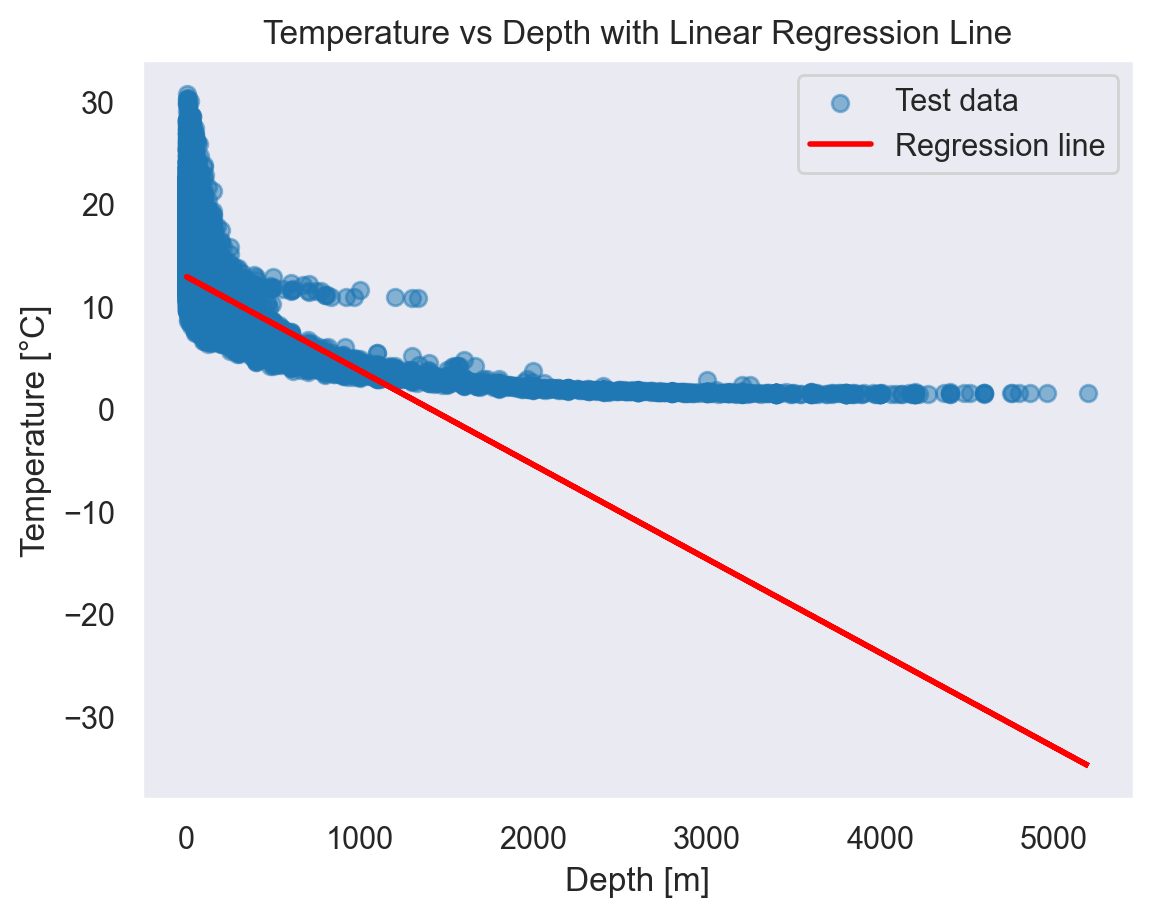

In [209]:
plt.scatter(X_test_dep, y_test, alpha=0.5, label='Test data')
plt.plot(X_test_dep, y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature vs Depth with Linear Regression Line')
plt.legend()
plt.grid()
plt.show()

In [210]:
print_metrics(y_test, y_pred)

Linear Regression Results (Depth only):
RMSE: 3.1276 °C
R² Score: 0.4433


### Polynomial Regression

*   Adapt linear regression by transforming data according to basis functions

*   E.g., with a polynomial projection:
    $$\hat{y} = a_0 + a_1 x + a_2 x^2 + \cdots + a_n x^n$$

*   Note that this is still a linear model

    *   It is linear in the sense that we never multiply or divide the coefficients

    *   The one-dimensional descriptor $x$ is projected in one or more dimensions to allow modeling more complex relations between $x$ and $y$

*   Try predicting the temperature based on depth only using a polynomial regression (e.g., until `degree=5`).

*   Evaluate the model using the RMSE and the R2 score.

*   Plot the test data and the predicted curve.

In [211]:
poly = PolynomialFeatures(degree=5)

X_train_dep_poly = poly.fit_transform(X_train_dep)
X_test_dep_poly = poly.transform(X_test_dep)

In [212]:
lin_reg.fit(X_train_dep_poly, y_train)

y_pred_poly = lin_reg.predict(X_test_dep_poly)

In [213]:
print_metrics(y_test, y_pred_poly)

Linear Regression Results (Depth only):
RMSE: 3.8280 °C
R² Score: 0.1660


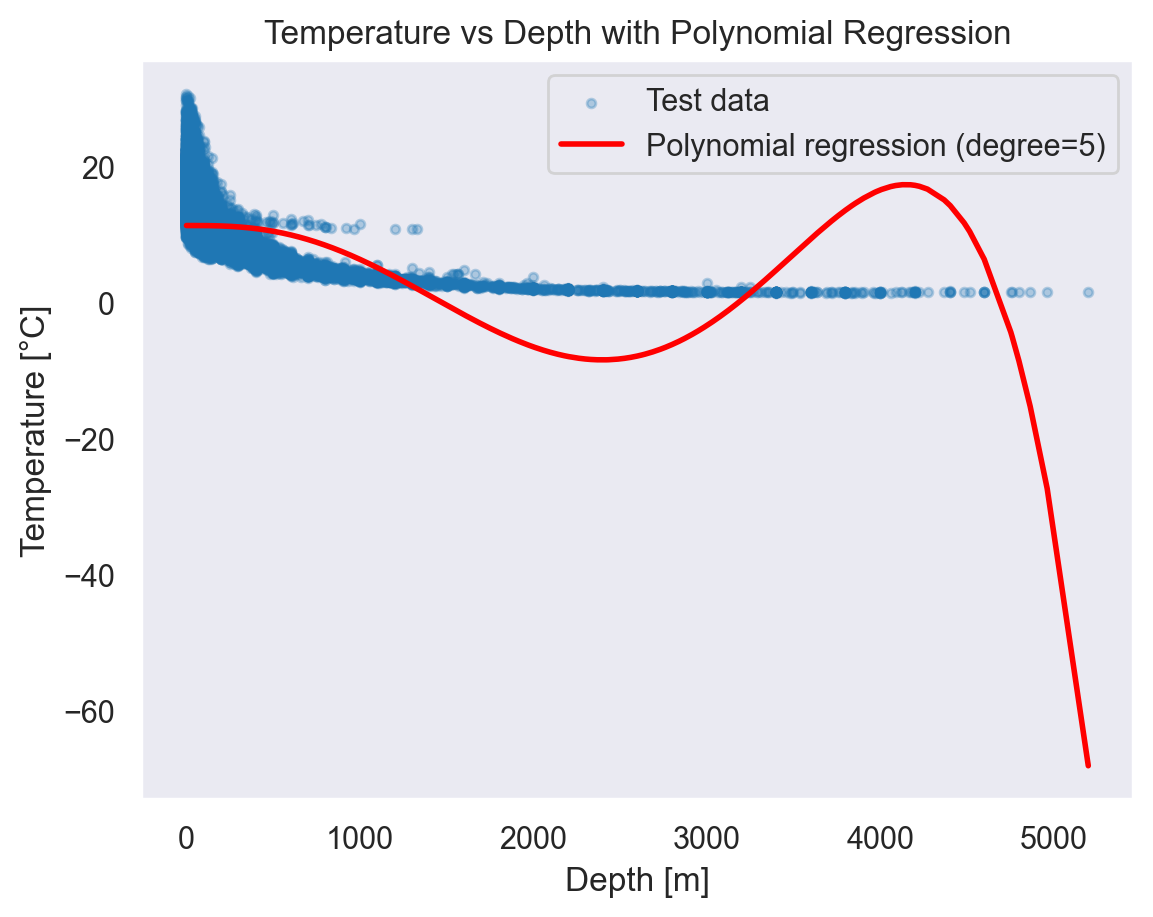

In [214]:
sort_idx = np.argsort(X_test_dep.values.ravel())
X_test_sorted = X_test_dep.values.ravel()[sort_idx]
y_pred_sorted = y_pred_poly[sort_idx]

plt.scatter(X_test_dep, y_test, alpha=0.3, label='Test data', s=10)
plt.plot(X_test_sorted, y_pred_sorted, color='red', linewidth=2, label='Polynomial regression (degree=5)')
plt.xlabel('Depth [m]')
plt.ylabel('Temperature [°C]')
plt.title('Temperature vs Depth with Polynomial Regression')
plt.legend()
plt.grid()
plt.show()

<span style="color:red">Implement your solution below</span>

#### Multiple Linear Regression

*   Perform the linear regression again using the set of 5 features available instead of just one.

*   Evaluate the performance of the regression in terms of MSE and $R^2$.

*   Identify the features that seem the most significant for this regression, by observing the value of their respective parameter ($a_j$ via `model.coef_`).

*   Comment succinctly.

In [215]:
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

In [216]:
print_metrics(y_test, y_pred)

Linear Regression Results (Depth only):
RMSE: 0.7435 °C
R² Score: 0.9685


In [217]:
coefficients = lin_reg.coef_
feature_names = X_train.columns
feature_names

Index(['Cst_Cnt', 'Depthm', 'Salnty', 'O2ml_L', 'STheta'], dtype='object')

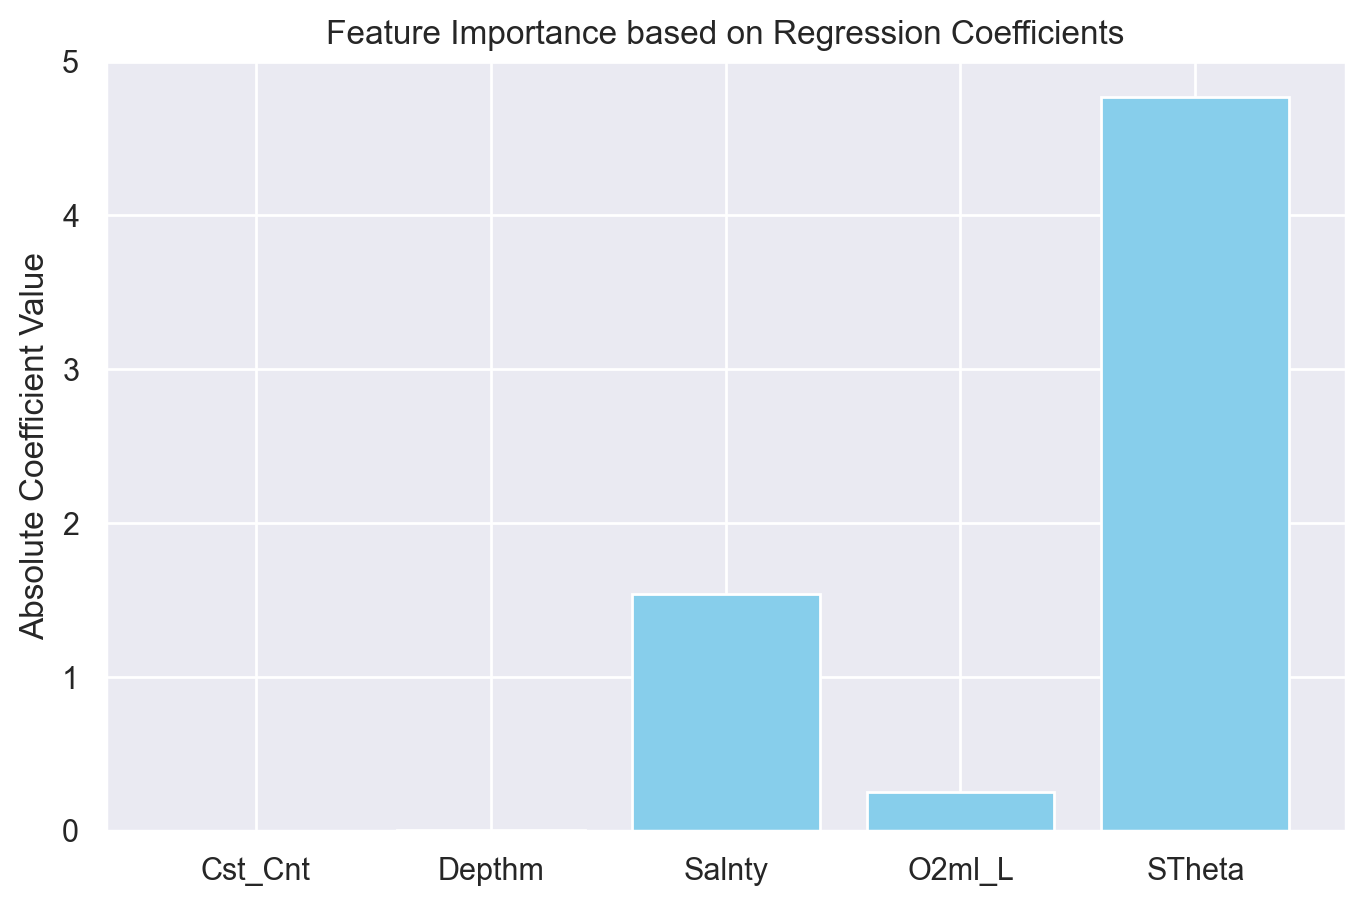

In [218]:
plt.figure(figsize=(8,5))
plt.bar(feature_names, np.abs(coefficients), color='skyblue')
plt.ylabel("Absolute Coefficient Value")
plt.title("Feature Importance based on Regression Coefficients")
plt.show()

In [219]:
body = "Using all 5 features with standardization dramatically improved performance (RMSE: 0.74 vs 3.13, R²: 0.97 vs 0.44). The coefficient analysis reveals that STheta (potential density) and O2ml_L (oxygen) are the most significant features for predicting temperature, which aligns with the strong correlations observed earlier (0.96 and 0.79 respectively). Depth alone provides limited predictive power, but combining multiple oceanographic variables captures the complex interdependencies governing water temperature."
print_formatted_response("Observation from the results", body)

Observation from the results
Using all 5 features with standardization dramatically improved performance
(RMSE: 0.74 vs 3.13, R²: 0.97 vs 0.44). The coefficient analysis reveals that
STheta (potential density) and O2ml_L (oxygen) are the most significant features
for predicting temperature, which aligns with the strong correlations observed
earlier (0.96 and 0.79 respectively). Depth alone provides limited predictive
power, but combining multiple oceanographic variables captures the complex
interdependencies governing water temperature.


### Standardization and PCA

Apply standardization and PCA to the dataset and repeat the regression and the evaluations.

The goal is to see if the performance of the regression improves and if the features that are the most significant change.

Try to analyze the results and comment on your observations (possibly with tables and plots similar to those in the PCA notebook).

<span style="color:red">Implement your solution below</span>

In [220]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [221]:
pca = PCA(n_components=5)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [222]:
lin_reg.fit(X_train_pca, y_train)

y_pred_pca = lin_reg.predict(X_test_pca)

In [223]:
lin_reg.coef_

array([ 2.94766086e-05, -9.26717227e-03,  1.23078119e+00, -4.76784847e+00,
       -9.55047613e-01])

In [224]:
coefficients = lin_reg.coef_
feature_names = X_train.columns
feature_names

Index(['Cst_Cnt', 'Depthm', 'Salnty', 'O2ml_L', 'STheta'], dtype='object')

In [225]:
pca.explained_variance_ratio_

array([9.99228462e-01, 7.71507852e-04, 2.80382194e-08, 1.54458879e-09,
       1.06395034e-09])

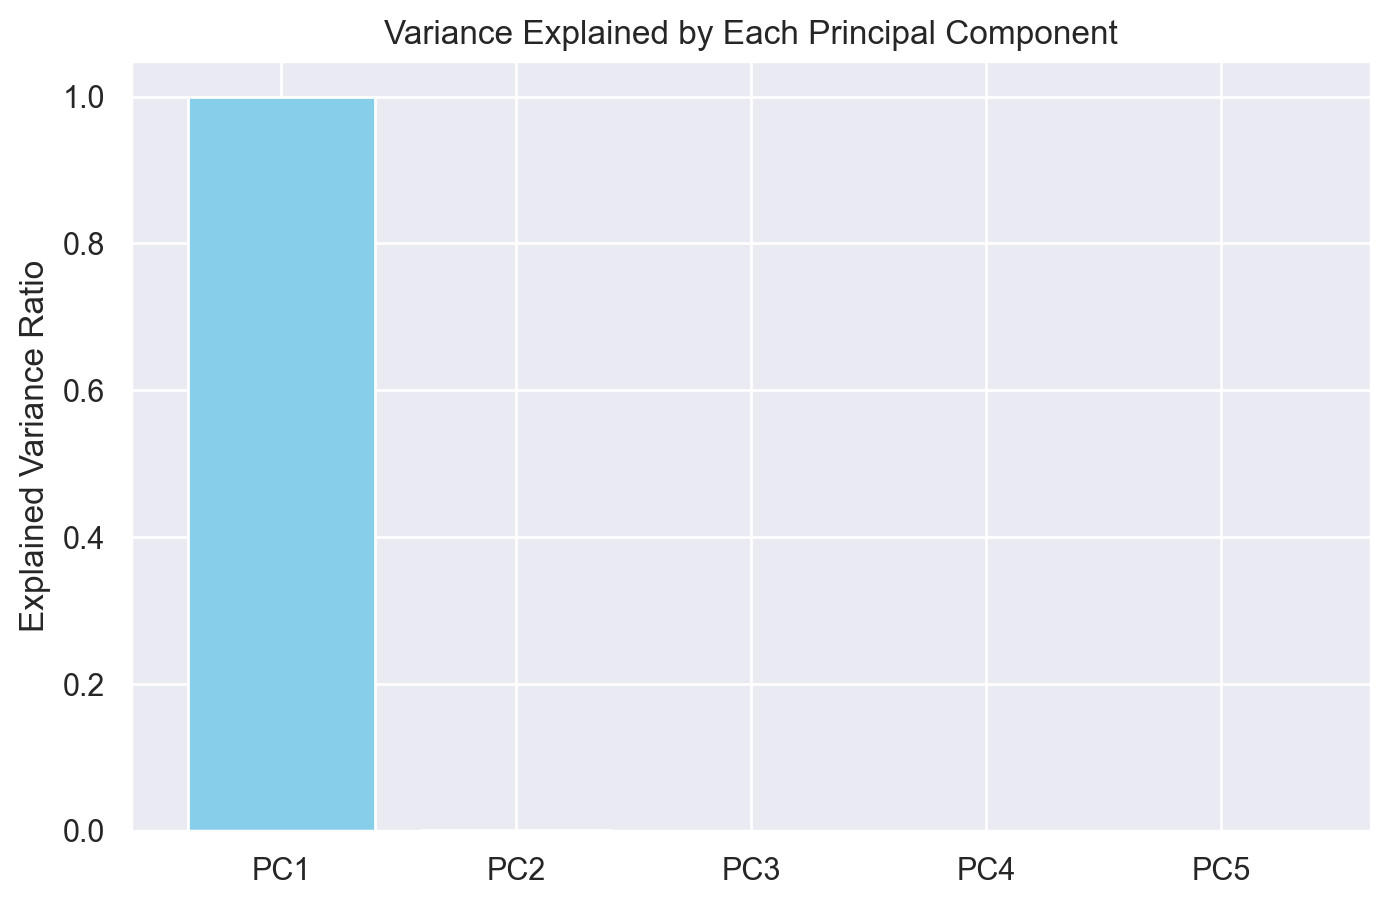

In [226]:
plt.figure(figsize=(8,5))
plt.bar(['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], pca.explained_variance_ratio_, color='skyblue')
plt.ylabel("Explained Variance Ratio")
plt.title("Variance Explained by Each Principal Component")
plt.show()

In [227]:
print_metrics(y_test, y_pred_pca)

Linear Regression Results (Depth only):
RMSE: 0.7435 °C
R² Score: 0.9685


In [228]:
header = "PCA Analysis"
body = "PCA regression achieves identical performance to standard multiple linear regression (RMSE: 0.74°C, R²: 0.97). The first principal component (PC1) explains 99.92% of the total variance, indicating extreme multicollinearity among the 5 oceanographic features. This reveals that temperature, salinity, oxygen, depth, and potential density are highly interdependent—essentially representing different aspects of the same underlying oceanographic phenomena. PCA successfully captures this redundancy, demonstrating that nearly all predictive information can be compressed into a single dimension without performance loss. This confirms the features contain substantial redundant information, making PCA an effective dimensionality reduction technique for this dataset."
print_formatted_response(header, body)

PCA Analysis
PCA regression achieves identical performance to standard multiple linear
regression (RMSE: 0.74°C, R²: 0.97). The first principal component (PC1)
explains 99.92% of the total variance, indicating extreme multicollinearity
among the 5 oceanographic features. This reveals that temperature, salinity,
oxygen, depth, and potential density are highly interdependent—essentially
representing different aspects of the same underlying oceanographic phenomena.
PCA successfully captures this redundancy, demonstrating that nearly all
predictive information can be compressed into a single dimension without
performance loss. This confirms the features contain substantial redundant
information, making PCA an effective dimensionality reduction technique for this
dataset.
